# Prototypage projet gpgpu

### Import libraries and data

In [1]:
import numpy as np
import scipy
import scipy.ndimage as ndimage
import skimage
import skimage.io
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
paths = !ls data/*.jpg | sort

In [3]:
paths

['data/barcode-00-01.jpg',
 'data/barcode-00-02.jpg',
 'data/barcode-00-03.jpg',
 'data/barres-pomme.jpg',
 'data/cereales.jpg',
 'data/infusion.jpg',
 'data/nutella.jpg',
 'data/sucre.jpg']

In [4]:
# Used for resizing
row, col, rgb, n_samples = 3024 / 2.1, 1920, 3, len(paths)

In [5]:
images_rgb = []
for path in paths:
    images_rgb.append(skimage.io.imread(path))

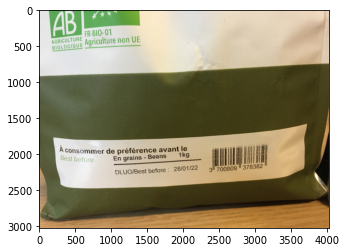

In [6]:
plt.imshow(images_rgb[0])

In [7]:
# Image can be nicely divided in 16x16 patches
row / 16, col / 16

(90.0, 120.0)

In [8]:
images = []
for image_rgb in images_rgb:
    images.append(rgb2gray(image_rgb))

# Generate the 16x16 patches / tiles

In [9]:
def generateTiles(image, tile_size=16):
    row, col = image.shape
    tiles = []
    for y in range(row // tile_size):
        line_tiles = []
        for x in range(col // tile_size):
            y_min, y_max = y * tile_size, (y + 1) * tile_size 
            x_min, x_max = x * tile_size, (x + 1) * tile_size 
            line_tiles.append(image[y_min:y_max, x_min:x_max])
        tiles.append(line_tiles)
    return np.array(tiles)

In [10]:
%%time
tiles = []
for image in images:
    tiles.append(generateTiles(image))

CPU times: user 500 ms, sys: 76.6 ms, total: 576 ms
Wall time: 582 ms


### For each patch / tile, extract every pixels 3x3 kernel neighbours feature vector

In [11]:
def getTileLocalPattern(tile):
    if tile.shape != (16, 16):
        raise Exception("Tile has invalid shape")

    res = []
    padded = np.pad(tile, pad_width=1, mode='constant', constant_values=0)

    for y in range(1, tile.shape[0] + 1):
        for x in range(1, tile.shape[1] + 1):
            # threshold to apply to neighbours
            threshold = padded[y, x]
            # get tile in 1d without current element
            y_min, y_max, x_min, x_max = y-1, y+1, x-1, x+1
            neighs = padded[y_min:y_max+1, x_min:x_max+1]
            neighs = neighs.reshape(-1)
            neighs = np.delete(neighs, neighs.size // 2)
            # apply filter
            res.append((neighs >= threshold).astype('uint8'))

    return np.array(res)

In [12]:
%%time
tile_pattern = getTileLocalPattern(tiles[0][0][0])

CPU times: user 4.97 ms, sys: 75 µs, total: 5.04 ms
Wall time: 4.49 ms


### For every patch's feature vector,  convert in texton

In [13]:
def getPatternHistogram(tile_pattern, tile_width=16):
    decArr = np.apply_along_axis(lambda arr: sum([val << i for i, val in enumerate(arr)]), 1, tile_pattern)
    return np.bincount(decArr, minlength=tile_width**2)

In [14]:
%%time
histo = getPatternHistogram(tile_pattern)

CPU times: user 4.72 ms, sys: 2.94 ms, total: 7.66 ms
Wall time: 7.63 ms


### Show histogram

(array([[253.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.],
        [200.,  56.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([  0.,  18.,  36.,  54.,  72.,  90., 108., 126., 144., 162., 180.]),
 <a list of 2 BarContainer objects>)

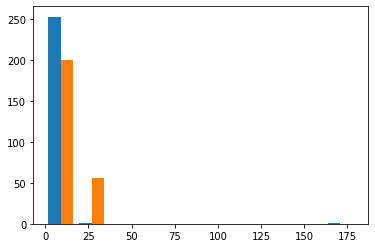

In [15]:
plt.hist(np.histogram(histo, bins=255))

### Apply the process to every tile and extract a tile feature map

In [16]:
def getTilesFeatures(tiles):
    res = []
    for y in range(tiles.shape[0]):
        for x in range(tiles.shape[1]):
            tile = tiles[y,x]
            localPattern = getTileLocalPattern(tile)
            histogram = getPatternHistogram(localPattern)
            res.append(histogram)

    return np.array(res)

In [17]:
# features = getTilesFeatures(tiles)

In [18]:
# features.shape

In [19]:
%%time
features = []
i = 0
for tile in tiles:
    feat = getTilesFeatures(tile)
    features.append(feat)
    np.save("features_{}".format(paths[i][5:-4]), feat)
    print("Image " + paths[i][5:-4] + " features computed and saved.")
    i += 1
# features.shape

Image barcode-00-01 features computed and saved.
Image barcode-00-02 features computed and saved.
Image barcode-00-03 features computed and saved.
Image barres-pomme features computed and saved.
Image cereales features computed and saved.
Image infusion features computed and saved.
Image nutella features computed and saved.
Image sucre features computed and saved.
CPU times: user 42min 51s, sys: 2.58 s, total: 42min 53s
Wall time: 43min 1s


In [20]:
features_train = []
for feature in features:
    features_train.append(feature.copy())

features_train = np.vstack(features_train)

## Make prediction on extracted data

In [21]:
def random_lut(n_values):
    '''Build a random LUT for `n_values` elements (sequential integers).'''
    samples = np.linspace(0, 1, n_values)  # take n_values values between 0 and 1 (evenly spaced)
    rng = np.random.default_rng(3)  # get a RNG with a specific seed
    samples = rng.permutation(samples)  # shuffle our values
    colors = cm.hsv(samples, alpha=None, bytes=True)  # get corresponding colors from the HSV color map
    return colors[...,:3]  # remove alpha channel and return

In [22]:
features_src = features.copy()

### Use MiniBatchKmeans

In [71]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

train_mean = features_train.mean(axis = 0)
features_scaled = features_train.copy()# MinMaxScaler().fit_transform(features)

n_clusters = 16
clusterer = MiniBatchKMeans(n_clusters, random_state=3)
clusterer.fit(features_scaled)

MiniBatchKMeans(n_clusters=16, random_state=3)

In [72]:
color_lut = random_lut(clusterer.n_clusters)

labels = []
predicted_rgb = []

for i in range(n_samples):
    _, col = images[i].shape
    labels.append(clusterer.predict(features[i]))
    labels[-1] = labels[-1].reshape(-1, col // 16)
    predicted_rgb.append(color_lut[labels[-1]])

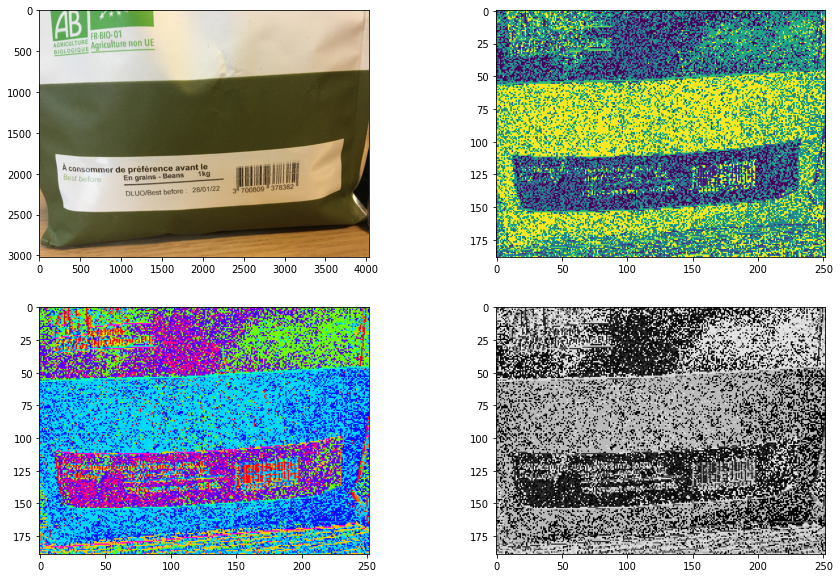

In [73]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(images_rgb[0], cmap='gray')
plt.subplot(222)
plt.imshow(labels[0])
plt.subplot(223)
plt.imshow(predicted_rgb[0])
plt.subplot(224)

plt.imshow(rgb2gray(predicted_rgb[0]), cmap='gray')

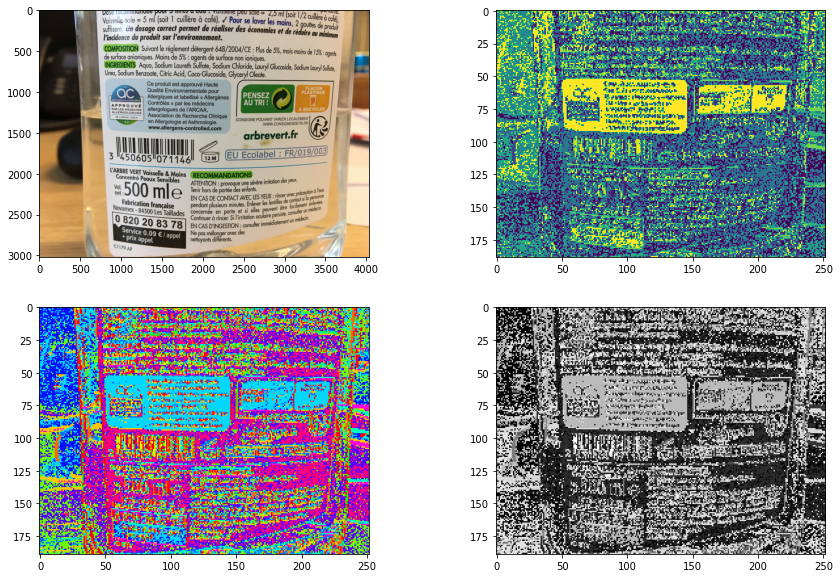

In [74]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(images_rgb[1], cmap='gray')
plt.subplot(222)
plt.imshow(labels[1])
plt.subplot(223)
plt.imshow(predicted_rgb[1])
plt.subplot(224)

plt.imshow(rgb2gray(predicted_rgb[1]), cmap='gray')

In [75]:
def keepCluster(image, predicted, class_):
    image = image.copy()
    image[predicted == class_] = 4269
    image[predicted != class_] = 0
    image[predicted == 4269] = 1
    plt.imshow(image)
    return image

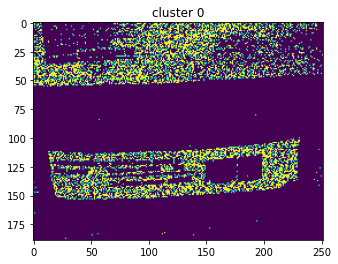

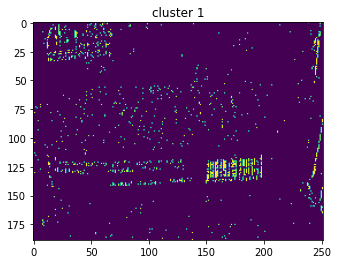

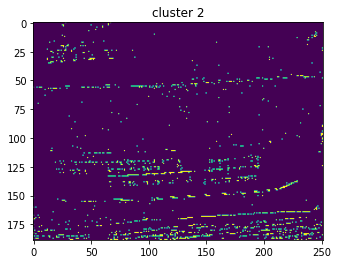

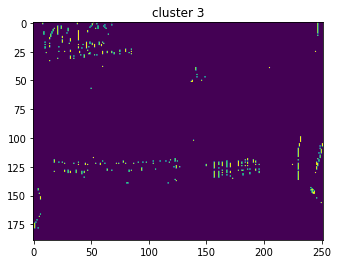

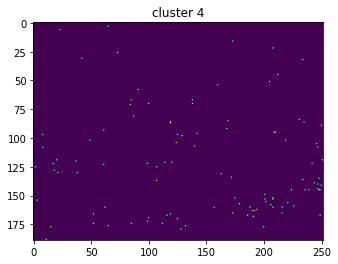

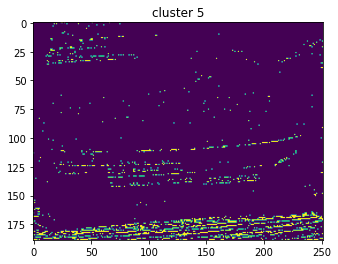

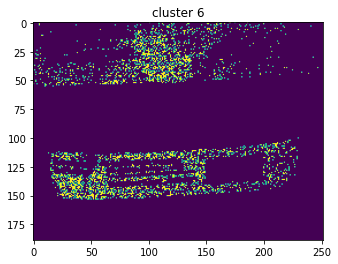

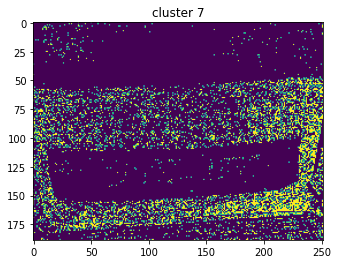

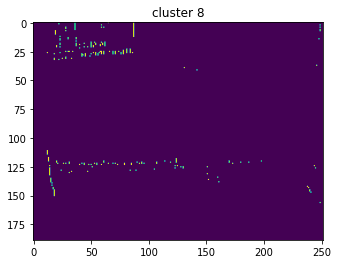

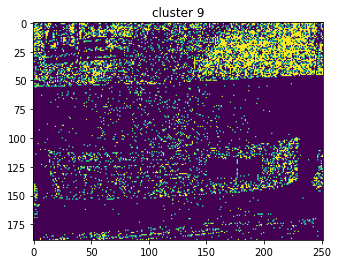

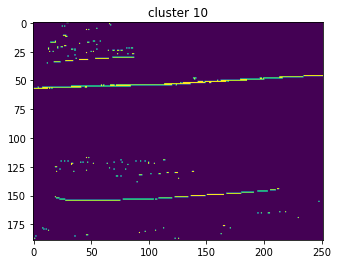

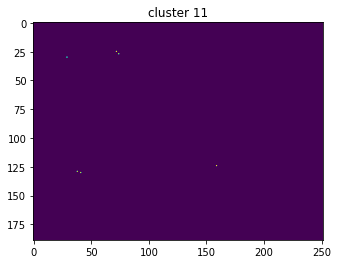

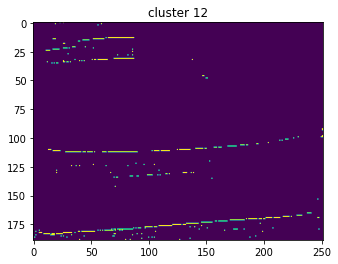

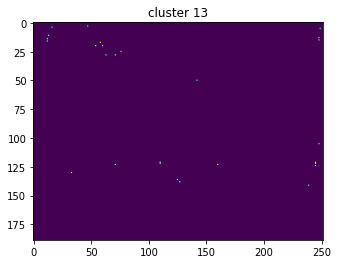

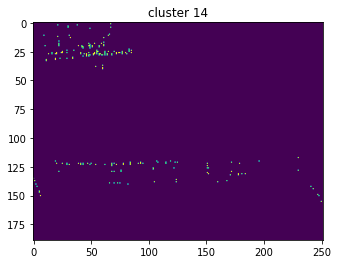

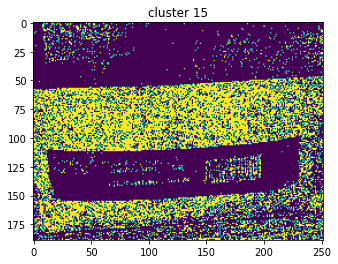

In [92]:
for i in range(clusterer.n_clusters):
    plt.figure()
    plt.title(f"cluster {i}")
    keepCluster(labels[0], labels[0], i)

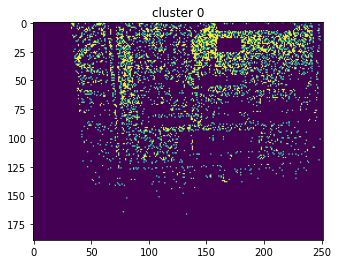

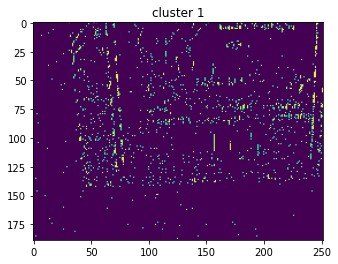

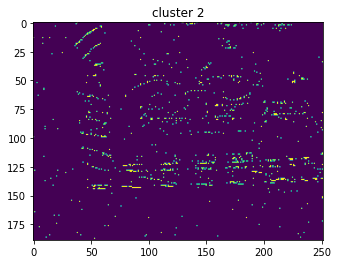

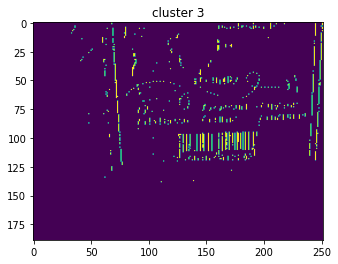

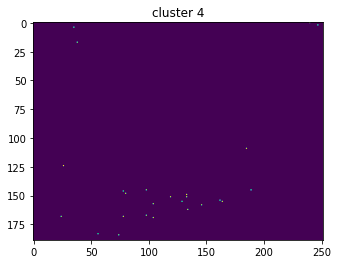

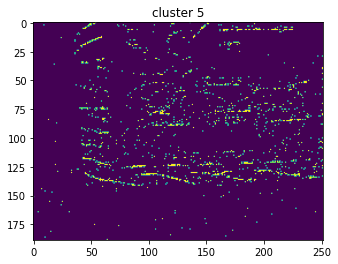

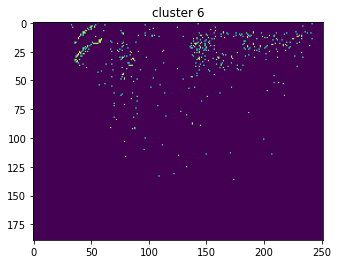

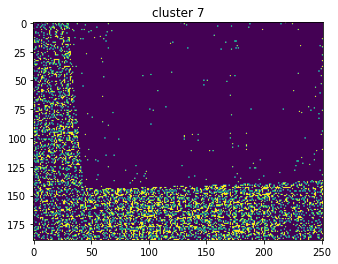

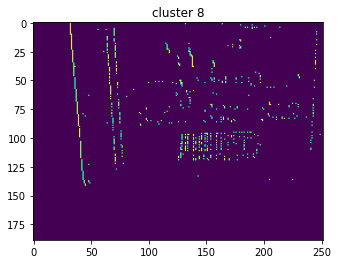

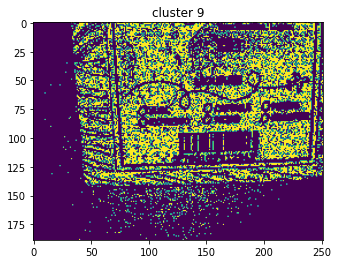

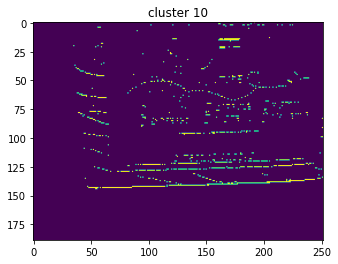

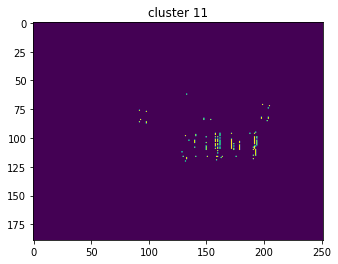

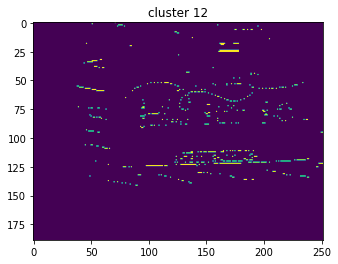

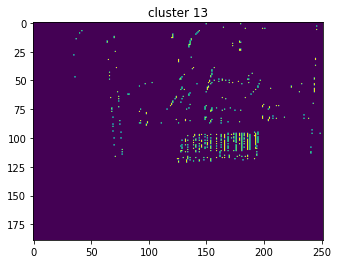

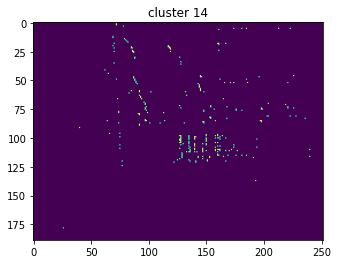

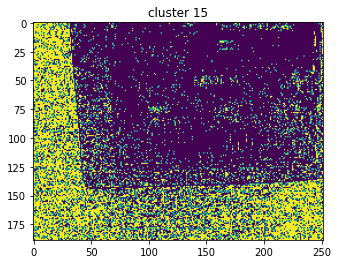

In [77]:
for i in range(clusterer.n_clusters):
    plt.figure()
    plt.title(f"cluster {i}")
    keepCluster(labels[2], labels[2], i)

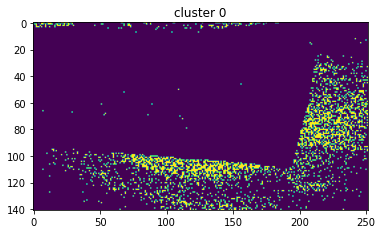

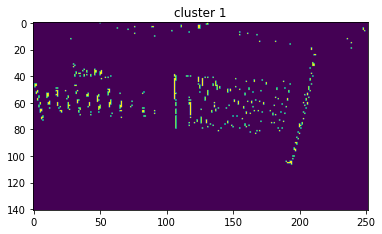

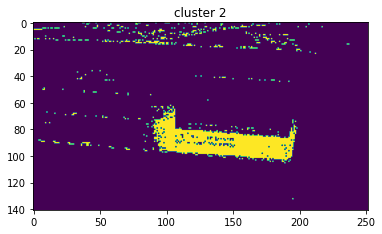

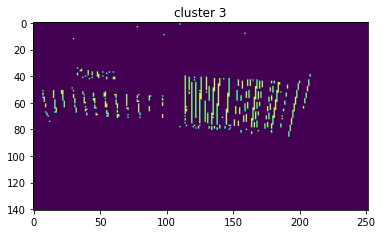

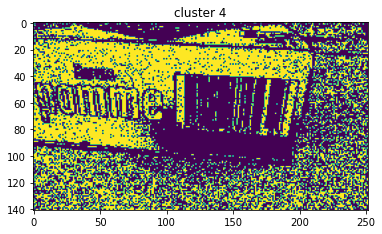

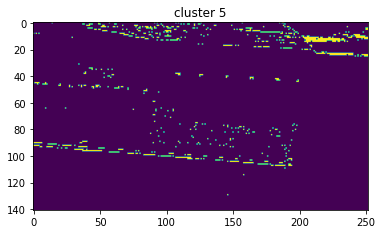

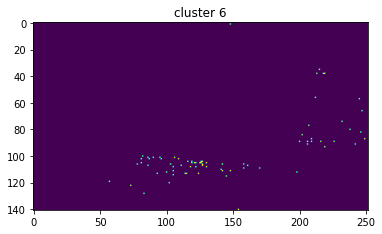

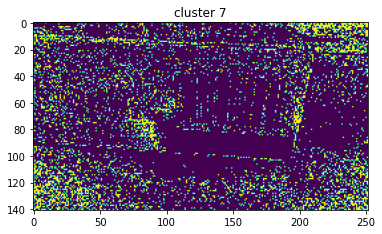

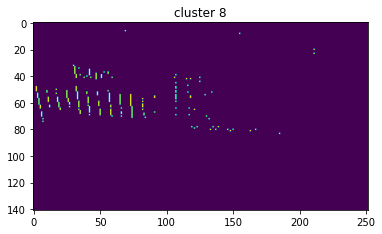

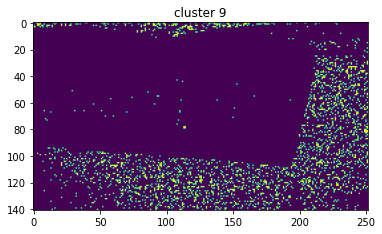

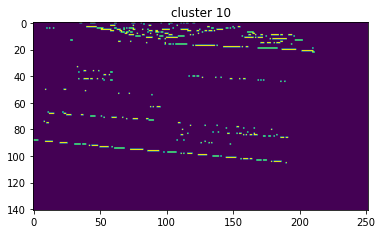

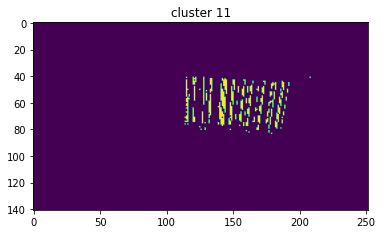

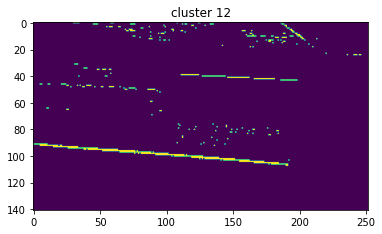

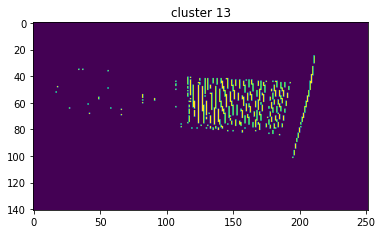

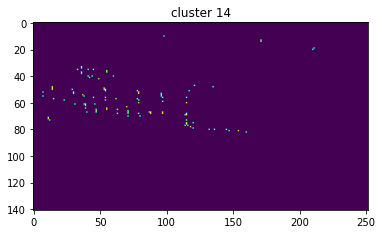

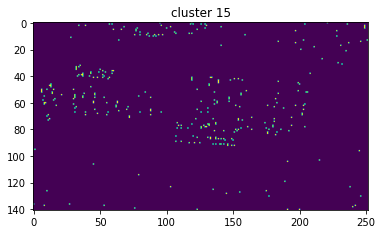

In [78]:
for i in range(clusterer.n_clusters):
    plt.figure()
    plt.title(f"cluster {i}")
    keepCluster(labels[3], labels[3], i)

array([[   0,    0, 4269, ..., 4269, 4269, 4269],
       [   0,    0,    0, ...,    0, 4269, 4269],
       [   0, 4269,    0, ...,    0,    0,    0],
       ...,
       [   0, 4269, 4269, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [4269,    0,    0, ...,    0,    0,    0]], dtype=int32)

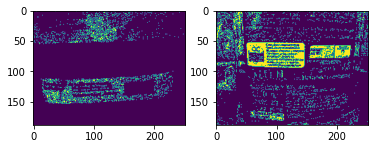

In [79]:
plt.subplot(121)
keepCluster(labels[0], labels[0], 6)
plt.subplot(122)
keepCluster(labels[1], labels[1], 15)

In [80]:
clusterer.cluster_centers_

array([[ 4.96744297,  0.19985741,  2.8956749 , ...,  2.49287072,
         4.25760456, 40.81273764],
       [10.73582888,  0.69411765,  4.91871658, ...,  2.52887701,
         2.25668449, 13.10374332],
       [11.46278027,  0.95964126,  3.03632287, ...,  1.38475336,
         1.03766816, 12.00717489],
       ...,
       [ 8.33650794,  0.51904762,  5.34285714, ...,  2.38095238,
         1.30793651,  7.37142857],
       [ 9.35301837,  0.75065617,  6.2664042 , ...,  2.89238845,
         0.91338583,  7.30708661],
       [ 9.84855082,  0.68567152,  4.34181521, ...,  2.73601851,
         1.52020683, 12.65110899]])

In [81]:
np.savetxt('kmeans.database', clusterer.cluster_centers_)

In [82]:
clusterer.n_clusters

16

# Faiss

In [83]:
import faiss
import numpy as np


class FaissKMeans:
    def __init__(self, n_clusters=8, n_init=10, max_iter=300):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.kmeans = None
        self.cluster_centers_ = None
        self.inertia_ = None

    def fit(self, X):
        self.kmeans = faiss.Kmeans(d=X.shape[1],
                                   k=self.n_clusters,
                                   niter=self.max_iter,
                                   nredo=self.n_init)
        self.kmeans.train(X.astype(np.float32))
        self.cluster_centers_ = self.kmeans.centroids
        self.inertia_ = self.kmeans.obj[-1]

    def predict(self, X):
        return self.kmeans.index.search(X.astype(np.float32), 1)[1]
    
    def fit_predict(self, X):
        self.fit(X)
        return self.predict(X)

In [84]:
n_clusters = 16
clustererFaiss = FaissKMeans(n_clusters)
clustererFaiss.fit(features_scaled)

In [85]:
labels_faiss = []
predicted_rgb_faiss = []

for i in range(n_samples):
    _, col = images[i].shape
    labels_faiss.append(clustererFaiss.predict(features[i]))
    labels_faiss[-1] = labels_faiss[-1].reshape(-1, col // 16)
    predicted_rgb_faiss.append(color_lut[labels_faiss[-1]])

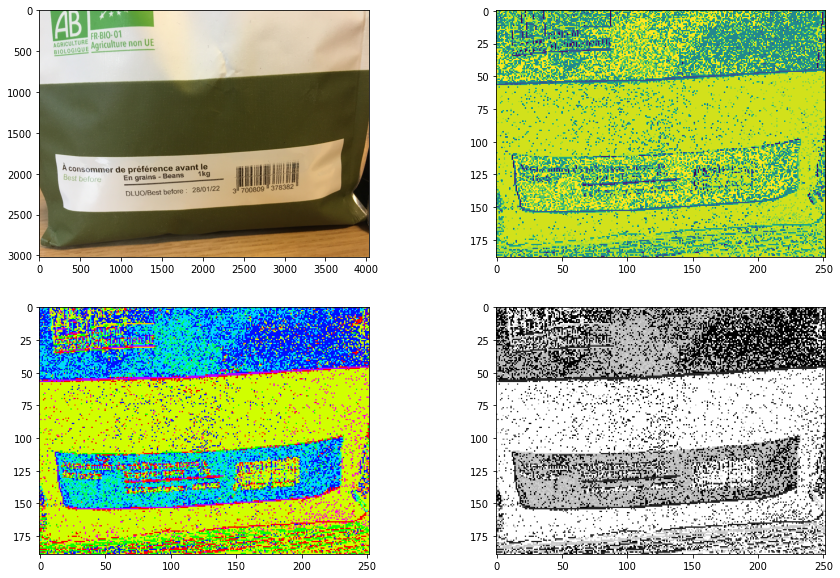

In [86]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(images_rgb[0], cmap='gray')
plt.subplot(222)
plt.imshow(labels_faiss[0])
plt.subplot(223)
plt.imshow(predicted_rgb_faiss[0])
plt.subplot(224)

plt.imshow(rgb2gray(predicted_rgb_faiss[0]), cmap='gray')

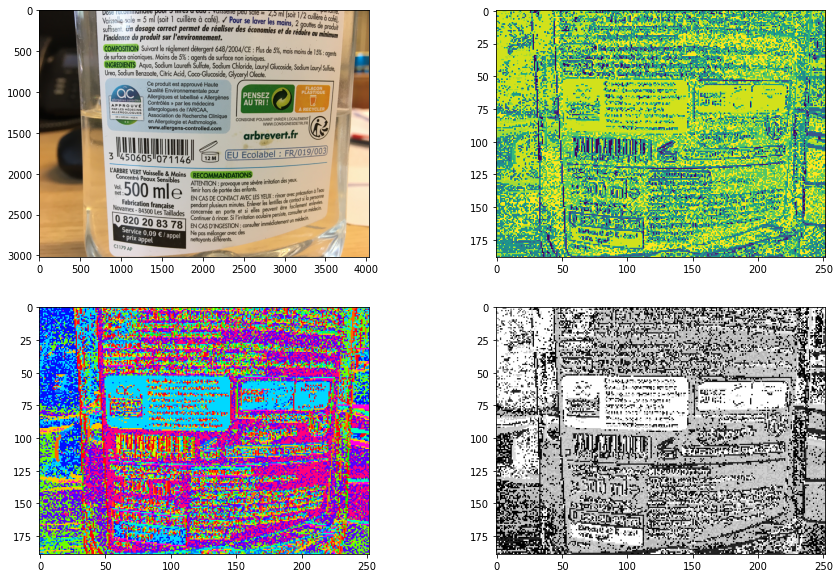

In [87]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(images_rgb[1], cmap='gray')
plt.subplot(222)
plt.imshow(labels_faiss[1])
plt.subplot(223)
plt.imshow(predicted_rgb[1])
plt.subplot(224)

plt.imshow(rgb2gray(predicted_rgb_faiss[1]), cmap='gray')

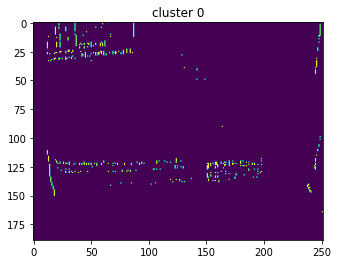

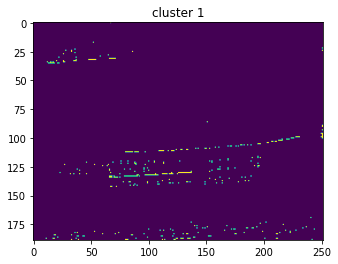

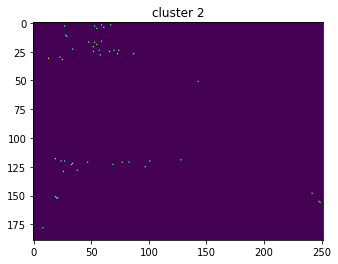

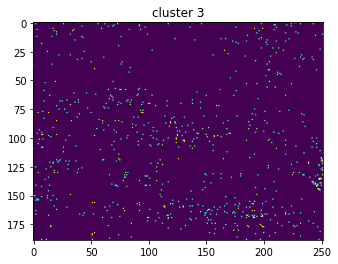

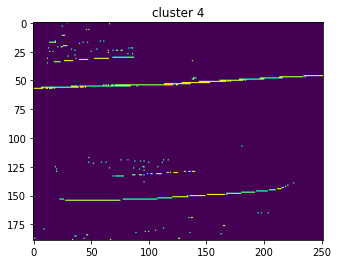

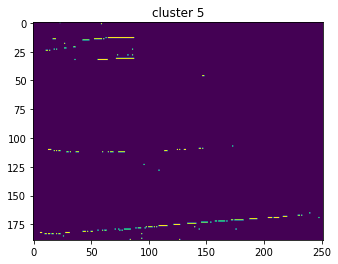

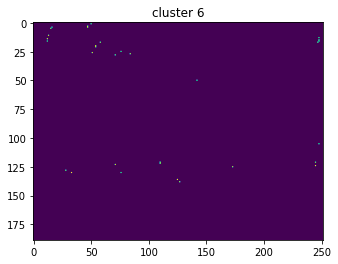

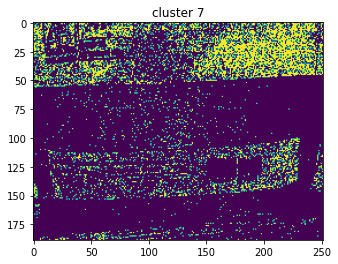

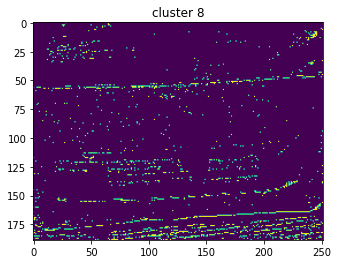

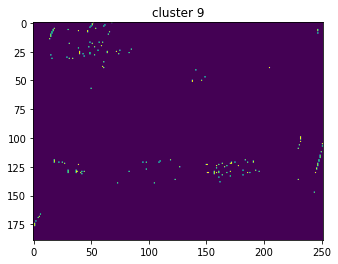

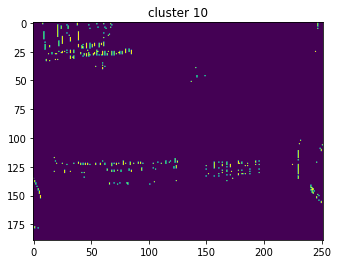

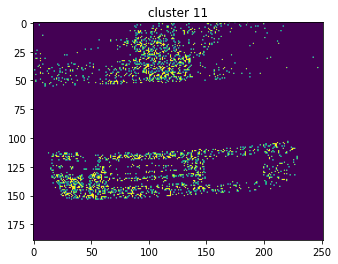

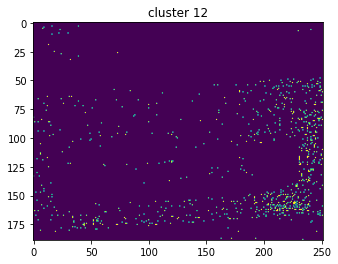

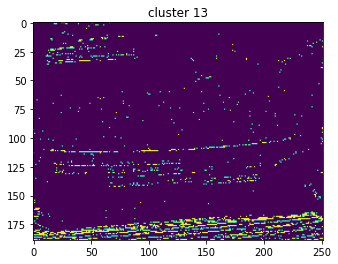

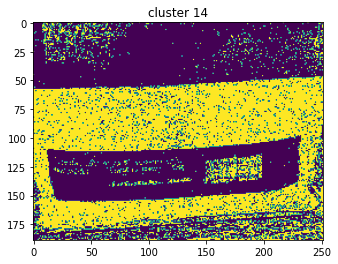

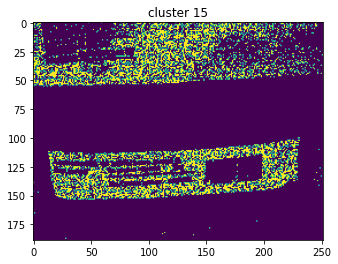

In [88]:
for i in range(clusterer.n_clusters):
    plt.figure()
    plt.title(f"cluster {i}")
    keepCluster(labels_faiss[0],labels_faiss[0], i)

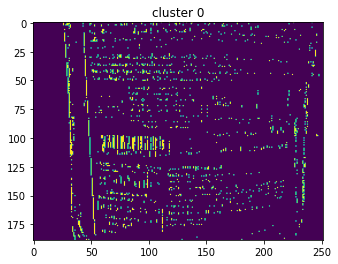

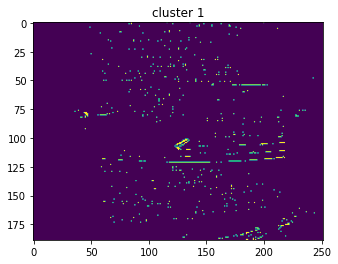

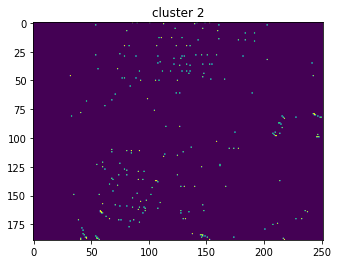

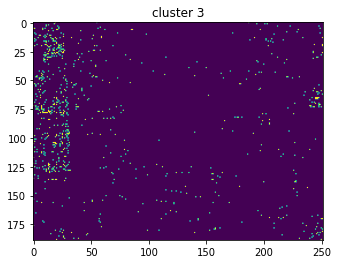

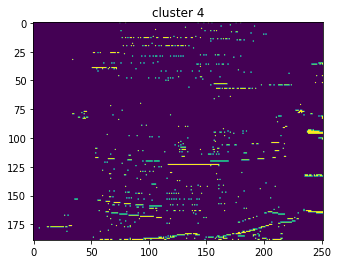

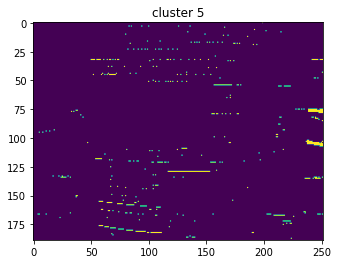

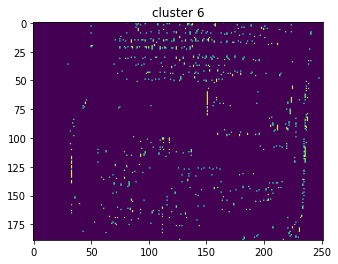

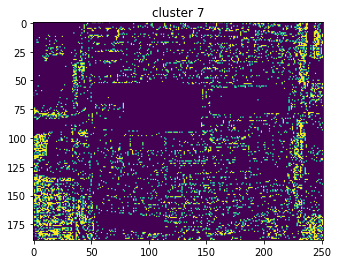

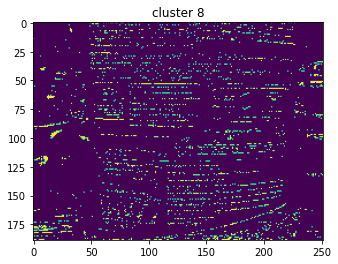

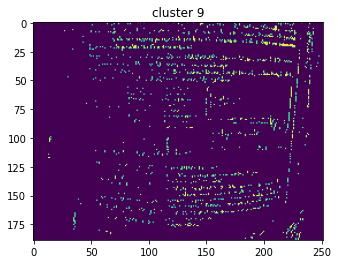

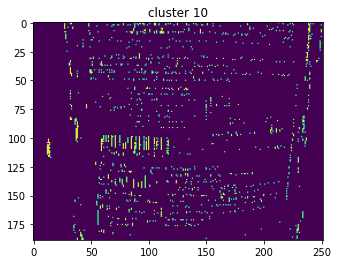

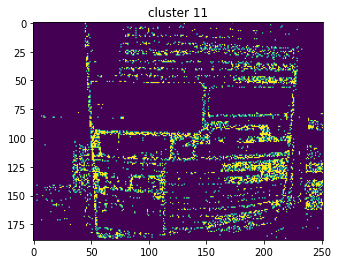

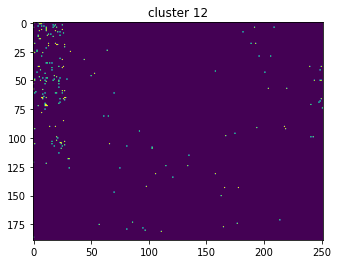

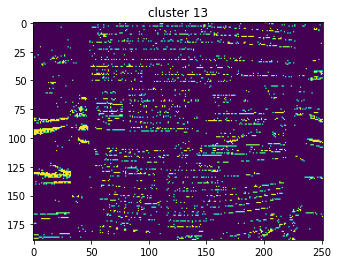

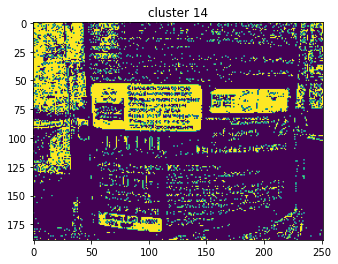

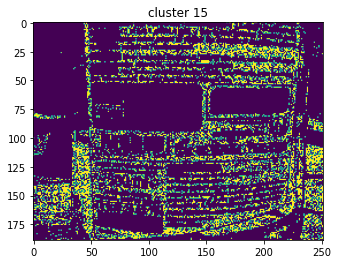

In [89]:
for i in range(clusterer.n_clusters):
    plt.figure()
    plt.title(f"cluster {i}")
    keepCluster(labels_faiss[1],labels_faiss[1], i)

# Saving the feature

In [90]:
# np.save("features_1", features[0])

In [91]:
# np.save("features_3", features[1])